In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
warnings.filterwarnings('ignore')

from pyinform.blockentropy import block_entropy

In [2]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_prediction_optiver/'

In [4]:
book_train_all_stocks = []
for i in range(127):
    try:
        book_train = pd.read_parquet(path + 'book_train.parquet/stock_id=' + str(i))
        book_train['stock_id'] = i
        book_train_all_stocks.append(book_train)
        print('added stock', i)
    except: 
        continue
book_train_all_stocks = pd.concat(book_train_all_stocks)
print('completed_concatenation')
book_train_all_stocks

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
1042044,32767,588,0.999229,1.000051,0.999177,1.000103,100,200,28,100,126
1042045,32767,589,0.999229,1.000051,0.999177,1.000103,100,200,1,100,126
1042046,32767,590,0.999229,0.999794,0.999177,1.000051,101,27,1,200,126
1042047,32767,592,0.999229,0.999743,0.999177,1.000051,101,11,1,200,126


In [3]:
trade_train_all_stocks = []
for i in range(127):
    try:
        trade_train = pd.read_parquet(path + 'trade_train.parquet/stock_id=' + str(i))
        trade_train['stock_id'] = i
        trade_train_all_stocks.append(trade_train)
        print('added stock', i)
    except: 
        continue
trade_train_all_stocks = pd.concat(trade_train_all_stocks)
print('completed_concatenation')
trade_train_all_stocks.head()

added stock 0
added stock 1
added stock 2
added stock 3
added stock 4
added stock 5
added stock 6
added stock 7
added stock 8
added stock 9
added stock 10
added stock 11
added stock 13
added stock 14
added stock 15
added stock 16
added stock 17
added stock 18
added stock 19
added stock 20
added stock 21
added stock 22
added stock 23
added stock 26
added stock 27
added stock 28
added stock 29
added stock 30
added stock 31
added stock 32
added stock 33
added stock 34
added stock 35
added stock 36
added stock 37
added stock 38
added stock 39
added stock 40
added stock 41
added stock 42
added stock 43
added stock 44
added stock 46
added stock 47
added stock 48
added stock 50
added stock 51
added stock 52
added stock 53
added stock 55
added stock 56
added stock 58
added stock 59
added stock 60
added stock 61
added stock 62
added stock 63
added stock 64
added stock 66
added stock 67
added stock 68
added stock 69
added stock 70
added stock 72
added stock 73
added stock 74
added stock 75
added

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [13]:
train_stock0 = pd.merge(book_train_all_stocks[book_train_all_stocks['stock_id']==0], trade_train_all_stocks[trade_train_all_stocks['stock_id']==0], on=['stock_id', 'time_id', 'seconds_in_bucket'], how='outer')
train_stock0.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0,NaN,NaN,NaN
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0,NaN,NaN,NaN
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0,NaN,NaN,NaN
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0,NaN,NaN,NaN


In [6]:
# get target
train_target = pd.read_csv(path + 'train.csv')
train_target.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [7]:
train_stock0['mid_price'] = (train_stock0['bid_price1'] + train_stock0['ask_price1']) / 2
train_stock0.dropna()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count,mid_price
13,5,21,1.001422,1.002818,1.001370,1.002922,3,30,2,100,0,1.002301,326.0,12.0,1.002120
17,5,46,1.002818,1.003232,1.002301,1.003801,155,1,200,34,0,1.002778,128.0,4.0,1.003025
20,5,50,1.002353,1.003025,1.002301,1.003232,3,20,100,301,0,1.002818,55.0,1.0,1.002689
23,5,57,1.002508,1.003646,1.002457,1.003749,200,104,28,200,0,1.003155,121.0,5.0,1.003077
27,5,68,1.002870,1.003749,1.002818,1.003801,100,100,11,34,0,1.003646,4.0,1.0,1.003310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917506,32767,471,0.998515,0.998802,0.998467,0.998850,90,29,200,1,0,0.998659,200.0,3.0,0.998659
917516,32767,517,0.998371,0.998802,0.998323,0.998850,90,1,110,1,0,0.998515,90.0,1.0,0.998587
917520,32767,523,0.998371,0.998802,0.998323,0.998850,90,87,100,1,0,0.998563,1.0,1.0,0.998587
917532,32767,542,0.998611,0.998946,0.998419,0.998994,90,29,200,28,0,0.998803,90.0,4.0,0.998778


In [8]:
train_stock0[train_stock0['size'] < 0]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id,price,size,order_count,mid_price


<Axes: xlabel='time'>

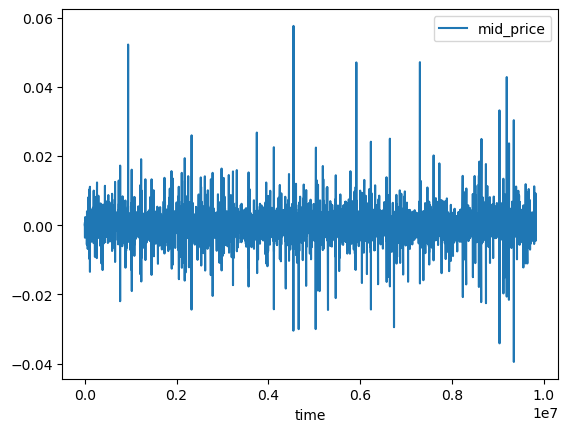

In [9]:
train_stock0['time'] = train_stock0['time_id'].astype(int)*60*5 + train_stock0['seconds_in_bucket']
train_stock0[['time', 'mid_price']].set_index('time').diff().plot()

In [9]:
from helper_functions.afml_functions.afml_modelling_lib import quantile_encode_series, shannon_entropy, encode_and_entropy

In [10]:
train_stock0['encoded_ret'] = quantile_encode_series(train_stock0['mid_price'].diff())

In [11]:
train_stock0['log_ret'] = np.log(train_stock0['mid_price']) - np.log(train_stock0['mid_price'].shift())

In [12]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([10, 15, 20], [10, 50, 100]):
    train_stock0['entropy'] = train_stock0[['time_id', 'log_ret']].dropna().groupby('time_id').apply(lambda x: shannon_entropy(quantile_encode_series(x['log_ret'], q).astype(str), L))
    stock0_entropy_target = pd.DataFrame(train_stock0['entropy'].dropna()).join(train_target[train_target['stock_id'] == 0].set_index('time_id')[['target']])
    mod = sm.OLS(stock0_entropy_target['target'], stock0_entropy_target[['entropy']])
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

10 10 0.6414634613006582
10 50 0.675963237347308
10 100 0.6804235007750903
15 10 0.6587687083480946
15 50 0.6804293454425816
15 100 0.6844188304728291
20 10 0.666285407952981
20 50 0.6812494791222357
20 100 0.6845347138729456
(20, 100) 0.6845347138729456


### features to construct
(all should be averages with the interval of interest)
- diff between VWAP and midprice
- volume imbalance
- spread
- gradient of bid side book (bid_size_1 - bid_size2)/(bid_price_2 - bid_price_1)
- gradient of ask side book
- entropy contained in encoded midprice (it looks like the mid price is stationary)
- entropy contained in fractionally differenced VWAP
- entropy in the differences
- average difference between trade price and ask (weighted by size)
- average difference between trade price and bid (weighted by size)
- vol of various quantities above
- correlation of stock with clustered stocks
- vol is mean reverting - would be good to put some mean reverting ideas in here (OU or some signal relating to this)

(calculate within a function to make life easier later!)
We'll try calibrating by instrument separately and then trying to get one general model, themn maybe we'll try something to combine

In [13]:
book_train_all_stocks.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [14]:
X = pd.DataFrame(book_train_all_stocks[['time_id', 'stock_id']])

In [44]:
X[X.duplicated(subset=['stock_id', 'time_id'], keep=False)]

,time_id,stock_id
0,5,0
1,5,0
2,5,0
3,5,0
4,5,0
...,...,...
1042044,32767,126
1042045,32767,126
1042046,32767,126
1042047,32767,126


In [17]:
from helper_functions.afml_functions.afml_data_analysis_lib import frac_diff_ffd
from sklearn.decomposition import PCA 

def calculate_on_all_time_points(df):
    # order book features
    df['VWAP'] = (df['bid_price1']*df['bid_size1'] + df['bid_price2']*df['bid_size2'] + df['ask_price1']*df['ask_size1'] + df['ask_price2']*df['ask_size2'])/(df['bid_size1'] + df['bid_size2'] + df['ask_size1'] + df['ask_size2'])
    df['mid_price'] = (df['ask_price1'] + df['bid_price1'])/2
    df['VWAP_mid_price_diff'] = df['VWAP'] - df['mid_price']
    df['volume_imbalance'] = df['ask_size1'] + df['ask_size2'] - df['bid_size1'] - df['bid_size2']
    df['spread'] = (df['ask_price1'] - df['bid_price1'])/df['mid_price']
    df['deeper_spread'] = df['ask_price2'] - df['bid_price2']
    df['spread_ratio'] = df['spread'] / df['deeper_spread']
    df['bid_gradient'] = (df['bid_size2'] - df['bid_size1'])/(df['bid_price2'] - df['bid_price1'])
    df['ask_gradient'] = (df['ask_size1'] - df['ask_size2'])/(df['ask_price1'] - df['ask_price2'])
    df['total_buy_interest'] = df['bid_price1'] + df['bid_price2']
    df['total_sell_interest'] = df['ask_price1'] + df['ask_price2']
    df['log_ret'] = np.log(df['mid_price']) - np.log(df['mid_price'].shift())

    # trade features
    df['bid_trade_diff'] = df['price'] - df['bid_price1']
    df['ask_trade_diff'] = df['ask_price1'] - df['price']
    return df

def weighted_average(data: pd.DataFrame, val_col: str, weights_col: str) -> float:
    return (data[val_col] * data[weights_col]).sum() / data[weights_col].sum()


def calculate_aggregate_features(df):
    # volume features
    aggregate = pd.DataFrame()
    aggregate['total_buy_interest'] = df[['time_id', 'stock_id', 'total_buy_interest']].groupby(['stock_id', 'time_id']).sum()
    aggregate['total_sell_interest'] = df[['time_id', 'stock_id', 'total_sell_interest']].groupby(['stock_id', 'time_id']).sum()
    aggregate['mean_buy_interest'] = df[['time_id', 'stock_id', 'total_buy_interest']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_sell_interest'] = df[['time_id', 'stock_id', 'total_sell_interest']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_imbalance'] = df[['time_id', 'stock_id', 'volume_imbalance']].groupby(['stock_id', 'time_id']).std()
    aggregate['total_imbalance_pct'] = (aggregate['total_buy_interest'] - aggregate['total_sell_interest']) / (aggregate['total_buy_interest'] + aggregate['total_sell_interest'])

    # traded volume features
    aggregate['total_traded_size'] = df[['time_id', 'stock_id', 'size']].groupby(['stock_id', 'time_id']).sum()
    aggregate['total_order_count'] = df[['time_id', 'stock_id', 'order_count']].groupby(['stock_id', 'time_id']).sum()
    aggregate['average_order_size'] = aggregate['total_traded_size'] / aggregate['total_order_count']
    aggregate['pct_interest_traded'] = aggregate['total_traded_size'] / (aggregate['total_buy_interest'] + aggregate['total_sell_interest'])

    # price features
    aggregate['mean_bid_trade_diff_weighted'] = df[['time_id', 'stock_id', 'bid_trade_diff', 'size']].groupby(['stock_id', 'time_id']).apply(lambda x: weighted_average(x, 'bid_trade_diff', 'size'))
    aggregate['mean_ask_trade_diff_weighted'] = df[['time_id', 'stock_id', 'ask_trade_diff', 'size']].groupby(['stock_id', 'time_id']).apply(lambda x: weighted_average(x, 'ask_trade_diff', 'size'))
    aggregate['mean_VWAP_mid_price_diff'] = df[['time_id', 'stock_id', 'VWAP_mid_price_diff']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_mid_price'] = df[['time_id', 'stock_id', 'mid_price']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_VWAP_mid_price_diff'] = df[['time_id', 'stock_id', 'VWAP_mid_price_diff']].groupby(['stock_id', 'time_id']).std()
    aggregate['std_ret'] = df[['time_id', 'stock_id', 'log_ret']].dropna().groupby(['stock_id', 'time_id']).std()
    aggregate['std_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].groupby(['stock_id', 'time_id']).std()
    aggregate['mean_bid_gradient'] = df[['time_id', 'stock_id', 'bid_gradient']].groupby(['stock_id', 'time_id']).mean()
    aggregate['mean_ask_gradient'] = df[['time_id', 'stock_id', 'ask_gradient']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_bid_gradient'] = df[['time_id', 'stock_id', 'bid_gradient']].groupby(['stock_id', 'time_id']).std()
    aggregate['std_ask_gradient'] = df[['time_id', 'stock_id', 'ask_gradient']].groupby(['stock_id', 'time_id']).std()
    aggregate['mean_spread_ratio'] = df[['time_id', 'stock_id', 'spread_ratio']].groupby(['stock_id', 'time_id']).mean()
    aggregate['std_spread_ratio'] = df[['time_id', 'stock_id', 'spread_ratio']].groupby(['stock_id', 'time_id']).std()

    # entropy features
    q, L = 20, 100
    aggregate['entropy_ret'] = df[['time_id', 'stock_id', 'log_ret']].dropna().groupby(['stock_id', 'time_id']).apply(lambda x: shannon_entropy(quantile_encode_series(x['log_ret'], q).astype(str), L))
    aggregate['entropy_VWAP'] = df[['time_id', 'stock_id', 'VWAP']].dropna().groupby(['stock_id', 'time_id']).apply(lambda x: shannon_entropy(quantile_encode_series(x['VWAP'], q).astype(str), L))
    aggregate['entropy_vol_ratio_ret'] = aggregate['entropy_ret'] / aggregate['std_ret']
    aggregate['entropy_vol_ratio_VWAP'] = aggregate['entropy_VWAP'] / aggregate['std_VWAP']

    # correlation features
    pca_stock_dict = df.groupby('time_id').apply(pca_correlation_measure)
    pca = dict_series_to_multi_index_df(pca_stock_dict)
    pca.columns = ['pca_corr']
    aggregate = aggregate.join(pca, how='inner')
    pearson_corr_stock_dict = df.groupby('time_id').apply(lambda x: corr(x, 'pearson'))
    pearson_corr = dict_series_to_multi_index_df(pearson_corr_stock_dict)
    pearson_corr.columns = ['pearson_corr']
    aggregate = aggregate.join(pearson_corr, how='inner')
    spearman_corr_stock_dict = df.groupby('time_id').apply(lambda x: corr(x, 'spearman'))
    spearman_corr = dict_series_to_multi_index_df(spearman_corr_stock_dict)
    spearman_corr.columns = ['spearman_corr']
    aggregate = aggregate.join(spearman_corr, how='inner')
    
    return aggregate

# could be made more efficient if we didnt have to do this every time for every stock but will accept for now...
# function has memory problems, lets come back to this
def pca_correlation_measure(df: pd.DataFrame) -> float:
    prices_pivoted = df[['seconds_in_bucket', 'stock_id', 'mid_price']].pivot(index='seconds_in_bucket', columns='stock_id', values='mid_price') 
    prices = prices_pivoted.fillna(method='ffill')
    returns = np.log(prices) - np.log(prices.shift())
    returns.dropna(inplace=True)
    pca = PCA(n_components=1)
    pca.fit(returns)
    stock_to_pca = dict(zip(list(prices.columns), list(pca.components_.flatten())))
    return stock_to_pca

def corr(df: pd.DataFrame, method: str = 'pearson'):
    prices_pivoted = df[['seconds_in_bucket', 'stock_id', 'mid_price']].pivot(index='seconds_in_bucket', columns='stock_id', values='mid_price') 
    prices = prices_pivoted.fillna(method='ffill')
    returns = np.log(prices) - np.log(prices.shift())
    returns.dropna(inplace=True)
    corr_matrix = returns.corr(method=method)
    mean_per_stock = corr_matrix.mean()
    stock_to_corr = dict(mean_per_stock)
    return stock_to_corr
    
    
def dict_series_to_multi_index_df(series: pd.Series):
    res = pd.DataFrame(series.tolist(), index=series.index) # convert the resulting series of dictionaries to a DataFrame
    res = res.stack().reset_index() # unstack the DataFrame to have time_id and stock_id as indices
    res.columns = ['time_id', 'stock_id', 'value']
    res.set_index(['time_id', 'stock_id'], inplace=True) # set time_id and stock_id as indices
    return res


In [57]:
time_ids = book_train_all_stocks['time_id'].unique()
i = 0
subset_time_id_length = 100
aggregate_features_list = []
while i <= time_ids[-1]:
    max_ind = min(time_ids[-1], i+subset_time_id_length)
    subset_book_train = book_train_all_stocks[(book_train_all_stocks['time_id'] >= i) & (book_train_all_stocks['time_id'] < max_ind)]
    subset_trade_train = trade_train_all_stocks[(trade_train_all_stocks['time_id'] >= i) & (trade_train_all_stocks['time_id'] < max_ind)]
    all_data = pd.merge(subset_book_train, subset_trade_train, how='outer', on=['stock_id', 'time_id', 'seconds_in_bucket'])
    features_all_time_points = calculate_on_all_time_points(all_data)
    aggregate_features = calculate_aggregate_features(features_all_time_points)
    aggregate_features_list.append(aggregate_features)
    i += subset_time_id_length
    print('pct complete:', i / time_ids[-1])

features = pd.concat(aggregate_features_list)
features.to_csv('generated_features_volatily_pred.csv')

pct complete: 0.0030518509475997192
pct complete: 0.0061037018951994385
pct complete: 0.009155552842799158
pct complete: 0.012207403790398877
pct complete: 0.015259254737998596
pct complete: 0.018311105685598315
pct complete: 0.021362956633198035
pct complete: 0.024414807580797754
pct complete: 0.027466658528397473
pct complete: 0.030518509475997192
pct complete: 0.033570360423596915
pct complete: 0.03662221137119663
pct complete: 0.03967406231879635
pct complete: 0.04272591326639607
pct complete: 0.04577776421399579
pct complete: 0.04882961516159551
pct complete: 0.05188146610919523
pct complete: 0.054933317056794946
pct complete: 0.05798516800439467
pct complete: 0.061037018951994385
pct complete: 0.0640888698995941
pct complete: 0.06714072084719383
pct complete: 0.07019257179479355
pct complete: 0.07324442274239326
pct complete: 0.07629627368999298
pct complete: 0.0793481246375927
pct complete: 0.08239997558519242
pct complete: 0.08545182653279214
pct complete: 0.08850367748039185
p

In [3]:
import pandas as pd
features = pd.read_csv('generated_features_volatily_pred.csv')
from helper_functions.general.feature_generation import NearestNeighbourFeature, ClusterFeature

In [4]:
from helper_functions.general.feature_selection import generate_heatmap, linear_model_with_pvalue_threshold, linear_model_with_anova_f_test, feature_importance_mdi_pmf_with_rf

#generate_heatmap(features.loc[100, :])

In [7]:
target = train_target.set_index(['stock_id', 'time_id'])
target_and_features = features.join(target, on=['stock_id', 'time_id'], how='inner')
target_and_features.dropna(inplace=True)

In [8]:
reduced_features = linear_model_with_pvalue_threshold(target_and_features.drop('target', axis=1), target_and_features['target'])[0]

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 4.532e+04
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:12:44   Log-Likelihood:             2.2079e+06
No. Observations:              428678   AIC:                        -4.416e+06
Df Residuals:                  428645   BIC:                        -4.415e+06
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [10]:
reduced_features

,stock_id,time_id,total_buy_interest,total_sell_interest,mean_buy_interest,mean_sell_interest,std_imbalance,total_imbalance_pct,total_traded_size,total_order_count,...,std_bid_gradient,std_ask_gradient,mean_spread_ratio,std_spread_ratio,entropy_ret,entropy_VWAP,entropy_vol_ratio_ret,entropy_vol_ratio_VWAP,pca_corr,spearman_corr
0,0,5,605.94867,606.56370,2.006453,2.008489,172.436952,-0.000507,3179.0,110.0,...,1.525469e+06,1.113258e+06,0.729696,0.156097,7.651052,7.658211,58569.725649,12661.345532,0.033576,0.019768
1,0,11,399.97617,400.18924,1.999881,2.000946,156.143772,-0.000266,1289.0,57.0,...,2.707682e+06,1.437666e+06,0.593092,0.152032,6.643856,6.643856,25424.413977,23838.034787,-0.004516,0.010111
2,0,16,375.66367,376.01044,1.998211,2.000056,178.710949,-0.000461,2161.0,68.0,...,1.542514e+06,1.270742e+06,0.665863,0.126691,6.459432,6.459432,54265.113103,9618.250271,0.000496,0.008271
3,0,31,239.60405,239.84607,1.996700,1.998717,177.646811,-0.000505,1962.0,59.0,...,2.343093e+06,2.010502e+06,0.753174,0.134220,4.321928,4.321928,16910.197885,7126.350530,-0.016873,0.011673
4,0,62,351.75772,351.95023,1.998623,1.999717,143.818118,-0.000274,1791.0,89.0,...,1.242280e+06,1.865566e+06,0.574738,0.125606,6.247928,6.247928,38596.560047,29576.728521,-0.005407,0.005921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428676,126,32750,429.83713,430.23337,1.999242,2.001085,204.958242,-0.000461,2201.0,120.0,...,2.181040e+06,1.432488e+06,0.723074,0.150099,6.845490,6.845490,39627.543893,10406.178501,-0.004797,0.006850
428677,126,32751,619.34894,619.98380,1.997900,1.999948,191.816892,-0.000512,2570.0,103.0,...,3.219414e+06,1.622995e+06,0.752790,0.150691,7.714246,7.714246,51140.472433,13310.619657,0.011415,-0.000308
428678,126,32753,446.87170,447.24713,2.003909,2.005593,169.722970,-0.000420,2323.0,147.0,...,2.294470e+06,1.047169e+06,0.726557,0.164299,6.942515,6.942515,41304.638510,5234.760887,0.003329,0.010265
428679,126,32758,512.18550,512.66160,2.000725,2.002585,183.311511,-0.000465,3740.0,98.0,...,2.607462e+06,7.126565e+05,0.663698,0.180188,7.285402,7.285402,21354.078925,15307.469893,-0.045080,0.005634


base model                             OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 5.179e+04
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:12:51   Log-Likelihood:             2.2079e+06
No. Observations:              428678   AIC:                        -4.416e+06
Df Residuals:                  428649   BIC:                        -4.415e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const

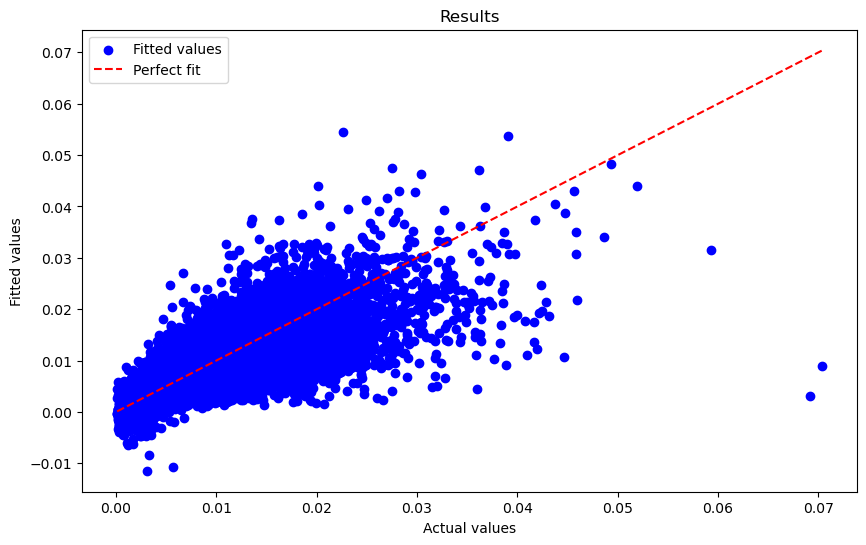

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x21f60280a90>,
         stock_id  time_id  total_buy_interest  total_sell_interest  \
 0              0        5           605.94867            606.56370   
 1              0       11           399.97617            400.18924   
 2              0       16           375.66367            376.01044   
 3              0       31           239.60405            239.84607   
 4              0       62           351.75772            351.95023   
 ...          ...      ...                 ...                  ...   
 428676       126    32750           429.83713            430.23337   
 428677       126    32751           619.34894            619.98380   
 428678       126    32753           446.87170            447.24713   
 428679       126    32758           512.18550            512.66160   
 428680       126    32763           799.22833            799.76245   
 
         mean_buy_interest  mean_sell_interest  std_imbalance  \

In [9]:
linear_model_with_anova_f_test(reduced_features, target_and_features['target'])

In [ ]:
feature_importance_mdi_pmf_with_rf(reduced_features, target_and_features['target'])

Lets take out some highly correlated features - removing the less important feature of the correlated features:
- total buy interest
- spearman corr
- mean sell interest
- entropy VWAP

In [10]:
reduced_features2 = reduced_features.drop(['total_buy_interest', 'spearman_corr', 'mean_sell_interest', 'entropy_VWAP'], axis=1)
reduced_features2

,stock_id,time_id,total_sell_interest,mean_buy_interest,std_imbalance,total_imbalance_pct,total_traded_size,total_order_count,average_order_size,pct_interest_traded,...,mean_bid_gradient,mean_ask_gradient,std_bid_gradient,std_ask_gradient,mean_spread_ratio,std_spread_ratio,entropy_ret,entropy_vol_ratio_ret,entropy_vol_ratio_VWAP,pca_corr
0,0,5,606.56370,2.006453,172.436952,-0.000507,3179.0,110.0,28.900000,2.621829,...,7.222810e+04,251573.914147,1.525469e+06,1.113258e+06,0.729696,0.156097,7.651052,58569.725649,12661.345532,0.033576
1,0,11,400.18924,1.999881,156.143772,-0.000266,1289.0,57.0,22.614035,1.610917,...,1.252707e+06,262724.084402,2.707682e+06,1.437666e+06,0.593092,0.152032,6.643856,25424.413977,23838.034787,-0.004516
2,0,16,376.01044,1.998211,178.710949,-0.000461,2161.0,68.0,31.779412,2.874916,...,-3.018593e+05,-403159.162694,1.542514e+06,1.270742e+06,0.665863,0.126691,6.459432,54265.113103,9618.250271,0.000496
3,0,31,239.84607,1.996700,177.646811,-0.000505,1962.0,59.0,33.254237,4.092188,...,1.020682e+06,-230996.391391,2.343093e+06,2.010502e+06,0.753174,0.134220,4.321928,16910.197885,7126.350530,-0.016873
4,0,62,351.95023,1.998623,143.818118,-0.000274,1791.0,89.0,20.123596,2.545090,...,3.280334e+05,-600471.856125,1.242280e+06,1.865566e+06,0.574738,0.125606,6.247928,38596.560047,29576.728521,-0.005407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428676,126,32750,430.23337,1.999242,204.958242,-0.000461,2201.0,120.0,18.341667,2.559093,...,3.714931e+05,-182276.689517,2.181040e+06,1.432488e+06,0.723074,0.150099,6.845490,39627.543893,10406.178501,-0.004797
428677,126,32751,619.98380,1.997900,191.816892,-0.000512,2570.0,103.0,24.951456,2.073696,...,1.327060e+06,139083.080681,3.219414e+06,1.622995e+06,0.752790,0.150691,7.714246,51140.472433,13310.619657,0.011415
428678,126,32753,447.24713,2.003909,169.722970,-0.000420,2323.0,147.0,15.802721,2.598089,...,3.748683e+05,146036.744478,2.294470e+06,1.047169e+06,0.726557,0.164299,6.942515,41304.638510,5234.760887,0.003329
428679,126,32758,512.66160,2.000725,183.311511,-0.000465,3740.0,98.0,38.163265,3.649325,...,5.057297e+05,128612.533062,2.607462e+06,7.126565e+05,0.663698,0.180188,7.285402,21354.078925,15307.469893,-0.045080


In [14]:
test = reduced_features.set_index('stock_id').pivot(columns='time_id', values='total_sell_interest')
test.mean()

time_id
5        895.218462
11       634.769112
16       710.649014
31       611.490407
62       626.178818
            ...    
32750    688.608706
32751    801.696209
32753    706.844983
32758    637.322360
32763    882.470046
Length: 3829, dtype: float64

Intead of the correlation features that have proven to be useless here, we can use k-nearest neighbours based on these features between other stocks, then use the neighbouring stocks features as features in the current stock. We may want to do this for every time point, or just some.

Not going to do this time based stuff like the others, im not entering the competion and this is not going to teach me anything useful in the long run (we observe ordered time IRL and we will not be able to use influences from future in a true predictive model)

In [15]:
# lets create nearest neighbour and clustering features
new_features = reduced_features2.set_index(['stock_id', 'time_id'])
for feature in new_features.columns:
    nn_feature = NearestNeighbourFeature(reduced_features2, 'stock_id', 'time_id', feature, 50)
    new_features = new_features.join(nn_feature.create_nearest_neighbour_feature(5, aggregate_function=np.mean, exclude_self=True))
    cluster_feature = ClusterFeature(reduced_features2, 'stock_id', 'time_id', feature, 5)
    new_features = new_features.join(cluster_feature.create_cluster_feature())
    print('added extra features for', feature)

new_features

added extra features for total_sell_interest
added extra features for mean_buy_interest
added extra features for std_imbalance
added extra features for total_imbalance_pct
added extra features for total_traded_size
added extra features for total_order_count
added extra features for average_order_size
added extra features for pct_interest_traded
added extra features for mean_bid_trade_diff_weighted
added extra features for mean_ask_trade_diff_weighted
added extra features for std_VWAP_mid_price_diff
added extra features for std_VWAP
added extra features for mean_bid_gradient
added extra features for mean_ask_gradient
added extra features for std_bid_gradient
added extra features for std_ask_gradient
added extra features for mean_spread_ratio
added extra features for std_spread_ratio
added extra features for entropy_ret
added extra features for entropy_vol_ratio_ret
added extra features for entropy_vol_ratio_VWAP
added extra features for pca_corr


total_sell_interest  mean_buy_interest  std_imbalance  \
stock_id time_id                                                          
0        5                  606.56370           2.006453     172.436952   
         11                 400.18924           1.999881     156.143772   
         16                 376.01044           1.998211     178.710949   
         31                 239.84607           1.996700     177.646811   
         62                 351.95023           1.998623     143.818118   
...                               ...                ...            ...   
126      32750              430.23337           1.999242     204.958242   
         32751              619.98380           1.997900     191.816892   
         32753              447.24713           2.003909     169.722970   
         32758              512.66160           2.000725     183.311511   
         32763              799.76245           2.003078     165.993902   

                  total_imbalance_pct  total_traded_size  total_order_count  \
stock_id time_id                                                              
0        5                  -0.000507             3179.0              110.0   
         11                 -0.000266             1289.0               57.0   
         16                 -0.000461             2161.0               68.0   
         31                 -0.000505             1962.0               59.0   
         62                 -0.000274             1791.0               89.0   
...                               ...                ...                ...   
126      32750              -0.000461             2201.0              120.0   
         32751              -0.000512             2570.0              103.0   
         32753              -0.000420             2323.0              147.0   
         32758              -0.000465             3740.0               98.0   
         32763              -0.000334             9389.0              234.0   

                  average_order_size  pct_interest_traded  \
stock_id time_id                                            
0        5                 28.900000             2.621829   
         11                22.614035             1.610917   
         16                31.779412             2.874916   
         31                33.254237             4.092188   
         62                20.123596             2.545090   
...                              ...                  ...   
126      32750             18.341667             2.559093   
         32751             24.951456             2.073696   
         32753             15.802721             2.598089   
         32758             38.163265             3.649325   
         32763             40.123932             5.871829   

                  mean_bid_trade_diff_weighted  mean_ask_trade_diff_weighted  \
stock_id time_id                                                               
0        5                            0.000450                      0.000375   
         11                           0.000249                      0.000223   
         16                           0.000295                      0.000311   
         31                           0.000452                      0.000325   
         62                           0.000311                      0.000120   
...                                        ...                           ...   
126      32750                        0.000333                      0.000381   
         32751                        0.000453                      0.000450   
         32753                        0.000314                      0.000380   
         32758                        0.000310                      0.000506   
         32763                        0.000203                      0.000362   

                  ...  std_spread_ratio_NearestNeighbours_5_mean  \
stock_id time_id  ...                                              
0        5        ...                      

In [28]:
new_features.join(checker)

total_sell_interest  mean_buy_interest  std_imbalance  \
stock_id time_id                                                          
0        5                  606.56370           2.006453     172.436952   
         11                 400.18924           1.999881     156.143772   
         16                 376.01044           1.998211     178.710949   
         31                 239.84607           1.996700     177.646811   
         62                 351.95023           1.998623     143.818118   
...                               ...                ...            ...   
126      32750              430.23337           1.999242     204.958242   
         32751              619.98380           1.997900     191.816892   
         32753              447.24713           2.003909     169.722970   
         32758              512.66160           2.000725     183.311511   
         32763              799.76245           2.003078     165.993902   

                  total_imbalance_pct  total_traded_size  total_order_count  \
stock_id time_id                                                              
0        5                  -0.000507             3179.0              110.0   
         11                 -0.000266             1289.0               57.0   
         16                 -0.000461             2161.0               68.0   
         31                 -0.000505             1962.0               59.0   
         62                 -0.000274             1791.0               89.0   
...                               ...                ...                ...   
126      32750              -0.000461             2201.0              120.0   
         32751              -0.000512             2570.0              103.0   
         32753              -0.000420             2323.0              147.0   
         32758              -0.000465             3740.0               98.0   
         32763              -0.000334             9389.0              234.0   

                  average_order_size  pct_interest_traded  \
stock_id time_id                                            
0        5                 28.900000             2.621829   
         11                22.614035             1.610917   
         16                31.779412             2.874916   
         31                33.254237             4.092188   
         62                20.123596             2.545090   
...                              ...                  ...   
126      32750             18.341667             2.559093   
         32751             24.951456             2.073696   
         32753             15.802721             2.598089   
         32758             38.163265             3.649325   
         32763             40.123932             5.871829   

                  mean_bid_trade_diff_weighted  mean_ask_trade_diff_weighted  \
stock_id time_id                                                               
0        5                            0.000450                      0.000375   
         11                           0.000249                      0.000223   
         16                           0.000295                      0.000311   
         31                           0.000452                      0.000325   
         62                           0.000311                      0.000120   
...                                        ...                           ...   
126      32750                        0.000333                      0.000381   
         32751                        0.000453                      0.000450   
         32753                        0.000314                      0.000380   
         32758                        0.000310                      0.000506   
         32763                        0.000203                      0.000362   

                  ...  mean_ask_gradient  std_bid_gradient  std_ask_gradient  \
stock_id time_id  ...                                                          
0        5        .

### Modelling

We can try these basic models, but it looks like from other solutions a neural network is very much required...

In [64]:
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet

pipeline_first_steps = [
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler()),
            ('pca', PCA())
]

pipeline1_steps = pipeline_first_steps.append(('random_forest', RandomForestRegressor()))
pipeline2_steps = pipeline_first_steps.append(('xgboost', xgb.XGBRegressor()))
pipeline3_steps = pipeline_first_steps.append(('linear_regression', LinearRegression()))
pipeline4_steps = pipeline_first_steps.append(('elastic_net', ElasticNet()))

def pipeline_func():
    return Pipeline(
        steps=pipeline1_steps
    )

# then pass this into a randomized search thingy then that into the functions we created previously for this stuff

There is still the argument of whether we should calibrate the stocks individual or overall, if we do overall calibration we can treat the stock as a categorical variable (which will be done by one hot encoding - note in a neural network  we use an Encoder which allows for efficient storage of the one hot encoded matric).
Hyperparameter tuning will be very long if we do it by stock - we are also assuming we can do KFold - which techmically we can't given everything is unordered.